In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import TIFArrayFile
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
import time
import os
from lib.utilities import *


In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/07-12-22/"
camera_program = 4

slice_target = 1
rec_target = 9

load_dic = False

process_all = False  # overrides slice/rec target to process all files

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}

if load_dic:
    dic_dir = data_dir + "dic/"

    cam_settings = CameraSettings().get_program_settings(camera_program)
    binning = int(cam_settings['height'] / 80)

    for filename in os.listdir(dic_dir):
        if filename.endswith(".tif"):

            tif = TIFArrayFile(filename, dic_dir, cam_settings, binning,
                              show_image=(str(slice_target) in filename and
                                          'e' in filename))

            img = tif.get_data()
            meta = tif.get_meta()
            slic = meta['slice_number']
            loc = meta['location_number']
            img_type = meta['img_type']

            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}

            single_images[slic][loc][img_type] = img



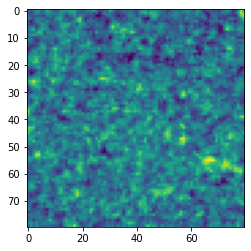

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") and filename[:3] != "ROI":
        map_type = filename[:3]
        name_parse = filename.split('.')[0][-8:]
        try:
            slic, loc, rec = [int(x) for x in name_parse.split('_')]
        except ValueError:
            continue
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        if map_type not in single_images[slic][loc]:
            single_images[slic][loc][map_type] = {}
        dat = np.loadtxt(dat_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(dat.shape[0]))
        dat = dat.reshape((width, width))
        if map_type == "SNR" and slic == slice_target and rec == rec_target:
            plt.imshow(dat)
        single_images[slic][loc][map_type][rec] = {
            'data': dat,
            'filename': filename
        }
        

In [5]:
# record stim amplitudes manually
stims = {}
# for 06-21-22
"""
single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]
"""

# for 07-12-22
single_images[1][1]['stims'] = [80, 60, 60, 50, 40] + [40 for _ in range(6, 24)]


In [6]:
roi = ROI_Identifier()

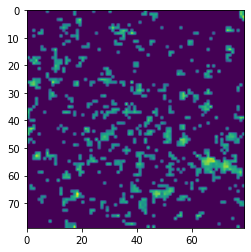

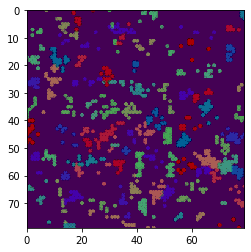

[[4862, 4702, 4785, 4625, 4624, 4786, 4705, 4782, 4703, 4706, 4626, 4707, 4783], [2104, 2103, 2178, 2021, 2027, 2098, 2177, 2026, 2183, 2097], [4044, 4283, 4285, 4607, 4366, 4284, 4286, 4449, 4127, 4365], [5378, 5296, 5298, 5534, 5458, 5457, 5614, 5379, 5535, 5456, 5297, 5460, 5377, 5537, 5459, 5536], [536, 867, 702, 708, 701]]


In [10]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec == rec_target):

                snr = single_images[slic][loc]['SNR'][rec]['data']
                sampled_points = roi.generate_points(snr, n_points=100000, 
                                                     percentile_cutoff=85,
                                                     upper_cutoff=100)

                w, h = snr.shape
                roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                k = 85
                
                if k is None:
                    # use AIC and elbow method, then enter choice of k above
                    roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                else: # after manually selecting k
                    labels = roi.gaussian_mixture_model(sampled_points, k, show=False)
                    
                    roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)
                    
                    # print ROIs to a DAT file to be loaded into PhotoZ
                    filename = dat_dir + "ROIs-" + single_images[slic][loc]['SNR'][rec]['filename']
                    ROIFileWriter().export_clusters(filename, labels, sampled_points, w, limit=5)
                
                    # find relevant signal statistic for time course
